In [1]:
# Checks if the code is in a colab notebook

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

Run on Colab notebook

In [2]:
if IN_COLAB:
  !pip install basicsr
  drive.mount('/content/drive/')
  !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_HR.zip
  !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_LR_clean.zip
  !unzip /content/drive/MyDrive/Datasets/DIV2K_train_LR_clean.zip
  #!unzip /content/drive/MyDrive/Datasets/DIV2K_train_HR.zip
  !unzip /content/drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/gen_images_0.zip
  FOLDER_LR_TEST = 'DIV2K_valid_LR_clean'
  FOLDER_HR_TEST = 'DIV2K_valid_HR'
  FOLDER_LR_TRAIN = 'DIV2K_train_LR_clean'
  #FOLDER_HR_TRAIN = 'DIV2K_train_HR'
  FOLDER_GEN_IMAGES = 'gen_images_0'

  STUDENT_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/student.pth'
  STUDENT_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/student.csv'
  GENERATOR_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/generator.pth'
  GENERATOR_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/generator.csv'
  DISCRIMINATOR_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/discriminator.pth'
  DISCRIMINATOR_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/discriminator.csv'
  
  PRUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son.pth'
  FINE_TUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son_fine.pth'

  TEACHER_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/ESRGAN_models/RealESRGAN_x4plus.pth'

Run on my Windows desktop

In [3]:
if not IN_COLAB:
  FOLDER_LR_TEST = 'D:\Downloads\Div2k\DIV2K_valid_LR_clean'
  FOLDER_HR_TEST = 'D:\Downloads\Div2k\DIV2K_valid_HR'
  FOLDER_LR_TRAIN = 'D:\Downloads\Div2k\DIV2K_train_LR_clean'
  FOLDER_HR_TRAIN = 'D:\Downloads\Div2k\DIV2K_train_HR'
  
  STUDENT_MODEL_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\student.pth'
  STUDENT_RECORDS_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\student.csv'
  GENERATOR_MODEL_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\generator.pth'
  GENERATOR_RECORDS_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\generator.csv'
  DISCRIMINATOR_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator.pth'
  DISCRIMINATOR_MODEL_PATH_24 = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator_24.pth'
  DISCRIMINATOR_RECORDS_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator.csv'
  FOLDER_GEN_IMAGES = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\gen_images_0'
  
  PRUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son.pth'
  FINE_TUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son_fine.pth'
  
  TEACHER_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\KD\ESRGAN_models\RealESRGAN_x4plus.pth'

# Setup

In [4]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import cv2
import csv
import math
import numpy as np
import os
import queue
import threading
from basicsr.archs.rrdbnet_arch import RRDBNet
import torchvision
from os import listdir, environ, path
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import vgg19

# Making sure to use the gpu, if available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_device(torch.device(0))

C:\Users\Vincent\anaconda3\envs\ai-robotics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, use_act: bool, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
    self.activation = nn.LeakyReLU(.2, inplace=True) if use_act else nn.Identity()

  def forward(self, x):
    return self.activation(self.conv(x))

class RDB(nn.Module):
  def __init__(self, in_channels, middle_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.block = nn.ModuleList([ConvBlock(in_channels + i * middle_channels,
                                  middle_channels if i<4 else in_channels,
                                  3,
                                  stride=1,
                                  padding=1,
                                  use_act=i<4) for i in range(5)])


  def forward(self, x):
    input = x
    for conv in self.block:
      out = conv(input)
      input = torch.cat([input, out], dim=1)
    return self.residual_scale * out + x

class RRDB(nn.Module):
  def __init__(self, in_channels, mid_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.model = nn.Sequential(*[RDB(in_channels, middle_channels = mid_channels, residual_scale = residual_scale) for _ in range(3)])
  
  def forward(self, x):
    return self.model(x) * self.residual_scale + x

class Head(nn.Module):
  def __init__(self, out_channels = 64) -> None:
    super().__init__()
    self.model = nn.Conv2d(3, out_channels, 3, stride=1, padding=1)

  def forward(self, x):
    return self.model(x)

class Tail(nn.Module):
  def __init__(self, in_channels = 64) -> None:
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(in_channels, 256, 3, stride=1, padding=1),
                               nn.Upsample(scale_factor=4, mode='nearest'),
                               nn.LeakyReLU(.2, inplace=True),
                               nn.Conv2d(256, 3, 3, stride=1, padding=1))
  
  def forward(self, x):
    return self.model(x)

# Original code for ESRGAN:
# https://github.com/xinntao/ESRGAN/blob/master/RRDBNet_arch.py

import functools
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_layer(block, n_layers, **kwargs):
    layers = []
    for _ in range(n_layers):
        layers.append(block(**kwargs))
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


class RRDBNet(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nf=64, nb=23, gc=32):
        super(RRDBNet, self).__init__()

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB, nb, nf=nf, gc=gc)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        feat = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(feat))
        feat = feat + trunk

        feat = self.lrelu(self.upconv1(F.interpolate(feat, scale_factor=2, mode='nearest')))
        feat = self.lrelu(self.upconv2(F.interpolate(feat, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(feat)))

        return out

In [6]:
class DIV2KEval(object):
    def __init__(self, folder, res_size: int = 48):
        self.folder = folder
        self.image_names = sorted(listdir(folder))
        self.len = len(self.image_names)
        self.resize = torchvision.transforms.Resize(res_size)
        
    def get_image(self, index: int):
        image = Image.open(Path(self.folder).joinpath(self.image_names[index]))
        return torchvision.transforms.ToTensor()(image)
    
    def __getitem__(self, index: int):
        # Get the right target image because we will use it resized version as input for the model
        image = self.get_image(index)
        return (self.resize(image),)
    
    def __len__(self):
        return self.len

    def restrict_size(self, size):
        if size < len(self.image_names) and size > 0:
            self.len = size
        else:
            self.len = len(self.image_names)
            print(f"Size must be between 0 and {len(self.image_names)}")

class DIV2KTrain(DIV2KEval):
    def __init__(self,  high_res_folder, low_res_size: int = 48, hr_resize_factor = 3):
        # We setup the HR folder and and (possible) resize as the basis for the parent class
        #
        # smallest dim: ~600 - We don't want to resize over 648 pixels because the smallest dimension of our
        # training HR images is 648px. We don't want the target image to have experienced any kind of super-resolution.
        crop_size = low_res_size*4
        
        # hr_target_size
        super().__init__(high_res_folder, int(crop_size * hr_resize_factor))
        
        self.crop_size = crop_size
        
        # smallest dim:: 48
        self.resize_lr = torchvision.transforms.Resize(low_res_size)

  
    def __getitem__(self, i):
        # Get the right target image because we will use it resized version as input for the model
        target = self.get_image(i)

        # The images having a resolution of 2040 pixels make it hard for our cropping of 48*4=192 pixels
        # to mimic a genuine image despite its advantage of showing great detailing.
        # Mainly because we only use a very small area of the image:
        #     (192*192)/(2040*1300) = 2%, in the case of an image with a smaller dimension of 1300 pixels.
        # This is why we introduce croppings of resized images that will capture more the elements of the HR image.
        #     (192*192)/(582*371) = 17%, if we divide the original proportions by 3.5
        # However, there is still a compromise between the loss of information induced when resizing the HR image down
        # and the amount of elements we retain when cropping the original image.
        # Hence why we use multiple scales when extracting these croppins.

        # This probablity is prone to decrease as the model gains more performance (with smaller learning rate)
        if torch.rand(1).item() < .99:
            # Resize the full image
            target = self.resize(target)

        # Crop of target image
        x, y, h, w = torchvision.transforms.RandomCrop.get_params(target, output_size=(self.crop_size, self.crop_size))
        target = torchvision.transforms.functional.crop(target, x, y, h, w)

        # Resizing for input image
        img = self.resize_lr(target)

        return img, target


In [7]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.L1Loss()
        self.vgg = vgg19(weights='DEFAULT').features[:35].eval().to(DEVICE)
        
        for param in self.vgg.parameters():
            param.requires_grad = False
    
    def forward(self, X, y):
        vgg_input_features = self.vgg(X)
        vgg_target_features = self.vgg(y)
        return self.loss(vgg_input_features, vgg_target_features)
    
class Trainer:
    def __init__(self, model):
        self.model = model
        self.opt = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = VGGLoss()
        self.pixel_loss = nn.L1Loss()
        self.cur_epoch = 0
        self.writer = SummaryWriter(f'runs/ESRGAN_Scratch/tensorboard')
        
    # Creates a new subfolder and assigns it for incoming metrics
    def update_writer(self):
        folders = sorted(listdir('runs/ESRGAN_Scratch'))
        next_id = 0
        for name in folders:
            if name[:4] == 'run_':
                next_id = int(name[4:]) + 1
        self.writer = SummaryWriter(f'runs/ESRGAN_Scratch/run_{next_id}')
    
    # This function shows the super-resolution of an image from the dataloader.
    def display_result(self, data: DIV2KEval, index:int = -1):
        if index < 0:
            index = torch.randint(len(data), (1,1))
        if index > len(data):
            print(f'Error: the given index {index} is greater than number of images {len(data)}')
            return
        
        display(torchvision.transforms.ToPILImage()(self.model(data[index][0].unsqueeze(dim=0).to(DEVICE))[0].clamp_(min=0., max=1.)))

    def run(self, dataloader, epochs, path_record: str = None, path_model: str = None, load_epoch: bool = False):
        # Initializes the records file if not existant
        if path_record and not Path(path_record).is_file():
            self.initialize_csv(path_record, nb_batches=len(dataloader))
            self.cur_epoch = 0
        elif load_epoch:
            # Loads the next epoch to continue training
            self.load_cur_epoch(path_record)
        
        # Initializes the summary writer to a new subfolder 
        self.update_writer()

        while self.cur_epoch < epochs:
            print(f'Epoch: {self.cur_epoch}')
            result = self.train_one_epoch(dataloader)
            loss, losses = result['epoch_loss'], result['batch_losses']
            print('****************************************\n')
            print(f'Total Loss: {loss}')

            self.writer.add_scalar('Training Loss - Epoch', loss, global_step = self.cur_epoch)
            
            if path_record:
                self.record(path_record, [self.cur_epoch, loss] + losses)
            if path_model:
                self.save(path_model)
            
            self.cur_epoch += 1

    def load_cur_epoch(self, path):
        with open(path) as records_file:
            epoch = records_file.readlines()[-1].split(',')[0]
            self.cur_epoch = int(epoch) + 1

    def load(self, path):
        saved_info = torch.load(path)
        self.model.load_state_dict(saved_info['model_state_dict'])
        self.opt = torch.optim.Adam(self.model.parameters(), lr=saved_info['lr'])
        self.cur_epoch = saved_info['epoch'] + 1
        # self.scheduler.load_state_dict(saved_info['lr_scheduler_state_dict'])
        self.loss_fn = saved_info['loss_fn']
        self.model.to(DEVICE)
        print("Model loaded successfully!")

    def save(self, path):
        torch.save({'model_state_dict': self.model.state_dict(),
                'lr': self.opt.param_groups[0]['lr'],
                'loss_fn': self.loss_fn,
                'epoch': self.cur_epoch,
                'lr_scheduler_state_dict': 0},
               path)
        print("Model saved successfully!")

    def initialize_csv(self, path, nb_batches: int = 0):
        columns = ['Epoch', 'Loss'] + [f'Batch Loss {i}' for i in range(nb_batches)]
        self.record(path, columns)
        print("Records created Successfully!")

    def record(self, path, row):
        with open(path, 'a', newline='') as f:
            csv.writer(f).writerow(row)
        print("Model recorded successfully!")

    def train_one_epoch(self, dataloader):
        cumu_loss = 0
        losses = [0]*len(dataloader)
        self.model.train()
        self.model.to(DEVICE)
        for batch, (X, y) in enumerate(dataloader):
            out = self.model(X.to(DEVICE))
            loss = self.learn(out, y)
            losses[batch] = loss
            cumu_loss += loss

            if batch % 1 == 0:
                print('------------------------------------------')
                print(
                    f'Training batch {batch} with loss {loss:.5f}')
            
            # Plot metrics to tensorboard
            self.writer.add_scalar('Training Loss - Batches', loss, global_step = self.cur_epoch * len(dataloader) + batch)
            self.writer.add_scalar(f'Training Loss - Batch n{batch}', loss, global_step = self.cur_epoch)
            out_grid = torchvision.utils.make_grid(out.clamp_(0.,1.))
            self.writer.add_image(f'Images batch {batch}', out_grid, global_step=self.cur_epoch)
            
        return {'epoch_loss': cumu_loss / len(dataloader), 'batch_losses': losses}

    def learn(self, out, y):
        y_cuda = y.to(DEVICE)
        p_w_loss = self.pixel_loss(out, y_cuda)
        loss = self.loss_fn(out, y_cuda) + p_w_loss
        
        print(f'L1 loss: {p_w_loss.item()}')

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        return loss.item()

# Training

In [8]:
if IN_COLAB:
    RECORDS_PATH = f'drive/MyDrive/ML/Indiv_Project/Second_Year/ESRGAN_Scratch/training.csv'
    MODEL_PATH = f'drive/MyDrive/ML/Indiv_Project/Second_Year/ESRGAN_Scratch/model.pth'
else:
    RECORDS_PATH = f'D:\oldDrive\ML\Indiv_Project\Second_Year\ESRGAN_Scratch\\training.csv'
    MODEL_PATH = f'D:\oldDrive\ML\Indiv_Project\Second_Year\ESRGAN_Scratch\model.pth'

model = RRDBNet()
trainer = Trainer(model)
trainer.load(MODEL_PATH)

data_train = DIV2KTrain(FOLDER_HR_TRAIN, hr_resize_factor=1)
data_train.restrict_size(400)
dl_train = DataLoader(data_train, batch_size=4)

Model loaded successfully!


In [14]:
trainer.run(dl_train, 2500, path_record=RECORDS_PATH, path_model=MODEL_PATH)

Epoch: 1058


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 6.00 GiB total capacity; 4.46 GiB already allocated; 0 bytes free; 4.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
#trainer.opt = torch.optim.Adam(trainer.model.parameters(), lr=1e-4)
trainer.opt.param_groups[0]['lr']

0.0001

- We trained the model on 400 images with a learning rate of 1e-4 for 200 epochs. The images are crops of the high resolution image.

- Add a probability of 4/5 to resize the full image then crop it instead of cropping immediately, until epoch 362
- Dropped learning rate to 1e-5 until epoch 630, saw a decrease in 0.05 in epoch loss. Epoch and batch losses are still very unstable.
- Dropped learning rate to 1e-6 for 50 epochs. Epoch and batch losses are still very unstable. I see minor changes
- Dropped learning rate to 1e-7 for 50 epochs. Epoch and batch losses are still very unstable. I see minor changes
- Dropped learning rate to 1e-12 for 50 epochs. Epoch and batch losses are still very unstable. I see minor changes
- (learning rate to 1e-3 made loss reach 1e5 => divergence)
- Resized the full image to the *crop_size* instead of 3 * *crop_size*. Also increased learning rate back to 1e-4. Model keeps learning steadily, might have a relatively small lr, maybe multiply it by 2 (we currently see an average decrease of 0.1/h). Saved the model
- initialized the training with l1 loss added to the vgg loss
- Error! Model save corrupted so we restart with the new combined loss from the old save (see "Resized the full...")

Next step: add l1 or l2 norm to the global loss.


ideas:
- train this model on bigger learning rate (x2 first and we save and check)
- increase the size of input images
- use l1 or l2 norm
- add l1 or l2 norm to the global loss.
- sgd
- modify momentum

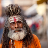

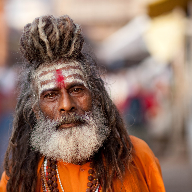

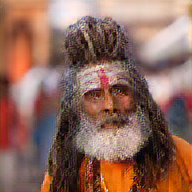

In [11]:
data_train = DIV2KTrain(FOLDER_HR_TRAIN, , hr_resize_factor=1)
data_train.restrict_size(400)
dl_train = DataLoader(data_train, batch_size=4)

o = data_train[89*4+2]
display(torchvision.transforms.ToPILImage()(o[0]))
display(torchvision.transforms.ToPILImage()(o[1]))
trainer.display_result(data_train, 89*4+2)

In [ ]:
trainer_pruned.display_result(data_train, 89*4+2)

In [21]:
data_test = DIV2KEval(FOLDER_HR_TRAIN, 2)

trainer.display_result(data_test, 89*4+2)

In [560]:
import pandas as pd

df = pd.read_csv('hr_dims.csv')
df.head()

,2040,1404
0,2040,1848
1,2040,1356
2,2040,1344
3,1608,2040
4,1356,2040


In [580]:
mins = df.min(axis=1)
df.min()

2040    1116
1404     648
dtype: int64

<Axes: >

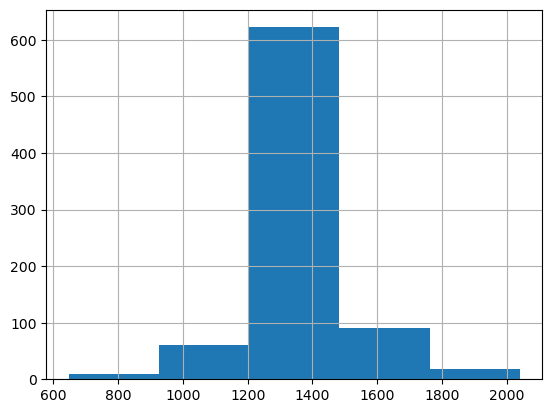

In [579]:
mins.hist(bins=5)

In [ ]:
trainer()